In [1]:
from base64 import b64encode
import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
import matplotlib

from sklearn.datasets import make_blobs
from IPython.display import display, HTML
from IPython.core.display import Video

# plt.style.use('dark_background')
# matplotlib.rcParams["figure.facecolor"] = "black"

In [2]:
def get_data(N, d, k):
  # data = np.random.randn(N, d)
  data, y = make_blobs(n_samples=N, n_features=d, centers=k, cluster_std=3)
  data = data[np.argsort(y)]
  return data

def get_init_topics(data, k=10):
    n, d = data.shape
    topics = np.zeros((n, k))
    assignments = np.random.randint(k, size=(n))
    topics[np.arange(n), assignments] = 1
    return topics

def get_cluster_centers(data, topics):
    topic_items = topics.T @ topics
    I = np.eye(*topic_items.shape)
    # Below is needed to ensure we don't get singular matrix error
    topic_items = np.maximum(topic_items, I)
    topic_total_vectors = topics.T @ data
    cluster_centers = np.linalg.inv(topic_items) @ topic_total_vectors
    return cluster_centers

def get_cluster_dists(data, cluster_centers):
    cluster_dists = np.linalg.norm(data[:, np.newaxis, :] - cluster_centers, axis=-1)
    return cluster_dists

def get_new_topics(cluster_dists, t=1e-5):
  return softmax(-cluster_dists/t, axis=-1)

def get_topic_similarity(topics):
  # cross_cluster_sim = (topics.T @ topics)/ np.diag(topics.T @ topics).sum()
  # print(cross_cluster_sim)
  # cluster_data_topics = np.vstack([cross_cluster_sim, np.zeros_like(topics[:1, :]), topics*2])
  cluster_data_sims = topics @ topics.T
  topic_ids = (topics.argmax(axis=-1))  + 1 # Add 1 to increment by 1
  cluster_data_topics = cluster_data_sims * topic_ids
  return cluster_data_topics

def run_iteration(data, topics):
  cluster_centers = get_cluster_centers(data, topics)
  cluster_dists = get_cluster_dists(data, cluster_centers)
  new_topics = get_new_topics(cluster_dists)
  cd = np.linalg.norm(topics - new_topics)
  return cluster_centers, cluster_dists, new_topics, cd

def decision_surface_factory(data, h=0.2):
  x_min, x_max = data[:, 0].min(), data[:, 0].max()+(2*h)
  y_min, y_max = data[:, 1].min(), data[:, 1].max()+(2*h)
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  mesh_data = np.c_[xx.ravel(), yy.ravel()]
  def _get_decision_surface(cluster_centers, h = 0.2):
    cluster_dists = get_cluster_dists(mesh_data, cluster_centers)
    topics = get_new_topics(cluster_dists, t=1e-5)
    topic_idx = np.argmax(topics, axis=-1)
    topic_idx = topic_idx.reshape(xx.shape)
    return xx, yy, topic_idx
  return _get_decision_surface


class KMeansPlot(object):
  def __init__(self, add_2d=False, use_display=True):
    self.nrows = 5
    self.ncols = 5
    self.add_2d = add_2d
    self.use_display = use_display
    # if self.add_2d:
    self.ncols += self.nrows

    self.fig = plt.figure(
      constrained_layout=False, 
      figsize=(2.5*self.ncols, 2.5*self.nrows),
      # facecolor="black"
    )


  def get_artists(self):
    artists = [
      self.im_data,
      self.im_topics,
      self.im_cluster_dists,
      self.im_cluster_centers,
      # self.im_new_topics,
    ]

    if self.add_2d:
      artists.extend([
        self.data_points,
        self.cluster_points,
        self.title,
      ])
    else:
      artists.extend([
        self.im_topic_sim
      ])
    return artists
    
    
  def setup(self, data, topics, cluster_centers, cluster_dists, new_topics, cd_all, title=""):
    fig = self.fig
    gs = plt.GridSpec(self.nrows, self.ncols, figure=fig)

    ax = fig.add_subplot(gs[0, :5])
    self.im_data = ax.imshow(data.T)
    ax.set_title("Data")

    ax = fig.add_subplot(gs[1, :5])
    self.im_topics = ax.imshow(topics.T)
    ax.set_title("clusters")

    ax = fig.add_subplot(gs[2, :5])
    self.im_cluster_dists = ax.imshow(cluster_dists.T)
    ax.set_title("cluster_dists")

    ax = fig.add_subplot(gs[3, :5])
    self.im_cluster_centers = ax.imshow(cluster_centers if cluster_centers.shape[1] > cluster_centers.shape[0] else cluster_centers.T)
    ax.set_title("cluster_centers" if cluster_centers.shape[1] > cluster_centers.shape[0] else "cluster_centers.T")


    self.ax_cd_all = fig.add_subplot(gs[4, :5])
    self.ax_cd_all.set_xlim(-1, 15)
    self.ax_cd_all.set_ylim(-1, cd_all[0]*1.1)
    self.ln_cd_all, = self.ax_cd_all.plot([], [])
    self.ax_cd_all.set_title("loss")

    # ax = fig.add_subplot(gs[4, :5])
    # self.im_new_topics = ax.imshow(new_topics.T)
    # ax.set_title("new_clusters")

    ax = fig.add_subplot(gs[:, 5:])

    if self.add_2d:  
      topic_idx = np.argmax(topics, axis=-1)
      k = topics.shape[-1]
      colors = np.array([f"C{i}" for i in range(k)])
      self.cmap = ListedColormap(colors)
      self.get_decision_surface = decision_surface_factory(data)
      # self.add_decision_surface(data, cluster_centers, ax)
      # d_colors = colors[topic_idx]
      self.decision_surface = ax.pcolormesh(*self.get_decision_surface(cluster_centers), cmap=self.cmap, rasterized=True, alpha=0.2)
      self.data_points = ax.scatter(data[:, 0], data[:, 1], marker="o", c=topic_idx, cmap=self.cmap, s=50, alpha=0.5)
      self.cluster_points = ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c=np.arange(k), cmap=self.cmap, s=300, alpha=0.9, marker="*")
      plt.colorbar(self.cluster_points)
      # title = f"Data: {title}"
    else:
      topic_sims = get_topic_similarity(topics)
      self.im_topic_sim = ax.imshow(topic_sims, cmap="viridis")
      plt.colorbar(self.im_topic_sim)
      # title = f"Data Topic Similarity: {title}"
    self.title = ax.set_title(title)
    
    if self.use_display:
      self.hdisplay = display(self.fig, display_id=True)
    return self.get_artists()

  def close(self):
    plt.close(self.fig)

  def update(self, data, topics, cluster_centers, cluster_dists, new_topics, cd_all, title=""):
    self.im_data.autoscale()
    self.im_data.set_data(data.T)

    self.im_topics.autoscale()
    self.im_topics.set_data(topics.T)

    self.im_cluster_dists.autoscale()
    self.im_cluster_dists.set_data(cluster_dists.T)

    self.im_cluster_centers.autoscale()
    self.im_cluster_centers.set_data(cluster_centers if cluster_centers.shape[1] > cluster_centers.shape[0] else cluster_centers.T)

    # self.ln_cd_all.autoscale()
    # ax.set_xlim(xmin, 2*xmax)

    # self.ax_cd_all.set_xlim(0, len(cd_all))
    # self.ax_cd_all.set_ylim(0, np.max(cd_all)*1.1)
    # self.ax_cd_all.figure.canvas.draw()
    self.ln_cd_all.set_data(np.arange(len(cd_all)), cd_all)

    # self.im_new_topics.autoscale()
    # self.im_new_topics.set_data(new_topics.T)

    if self.add_2d:
      topic_idx = np.argmax(topics, axis=-1)
      k = topics.shape[-1]
      colors = np.array([f"C{i}" for i in range(k)])
      decision_topics = self.get_decision_surface(cluster_centers)[-1]
      # Removing last indexes is needed as per: 
      # https://stackoverflow.com/questions/18797175/animation-with-pcolormesh-routine-in-matplotlib-how-do-i-initialize-the-data
      decision_topics = decision_topics[:-1, :-1]
      self.decision_surface.set_array(decision_topics.ravel())
      # d_colors = colors[topic_idx]
      self.data_points.set_offsets(data[:, :2])
      # self.data_points.set_color(d_colors)
      self.data_points.set_array(topic_idx)
      self.cluster_points.set_offsets(cluster_centers[:, :2])
      # title = f"Data: {title}"
    else:
      self.im_topic_sim.autoscale()
      topic_sims = get_topic_similarity(topics)
      self.im_topic_sim.set_data(topic_sims)
      # title = f"Data Topic Similarity: {title}"
    self.title.set_text(title)
      # self.hdisplay2.update(self.fig2)
    if self.use_display:
      self.hdisplay.update(self.fig)
    return self.get_artists()


def show_video(video_path):   
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video controls><source src="{video_url}"></video>""")


class AnimatedKMeansPlot(KMeansPlot):
  def get_animator_funcs(self, data, topics):
    cd_all = []
    def init():
      cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
      cd_all.append(cd)
      artists = self.setup(data, topics, cluster_centers, cluster_dists, new_topics, cd_all)
      return artists

    def update(i):
      nonlocal topics
      cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
      cd_all.append(cd)
      title = f"i={i}, norm_dist={cd}"
      if self.add_2d:
        title = f"Data: {title}"
      else:
        title = f"Data Topic Similarity: {title}"
      artists = self.update(data, topics, cluster_centers, cluster_dists, new_topics, cd_all, title);
      topics = new_topics
      return artists
    return init, update

In [3]:
N, d = 100, 2
k = 10
add_2d = (d == 2)

In [4]:
data = get_data(N, d, k)
topics = get_init_topics(data, k=k)
cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
new_topics.sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

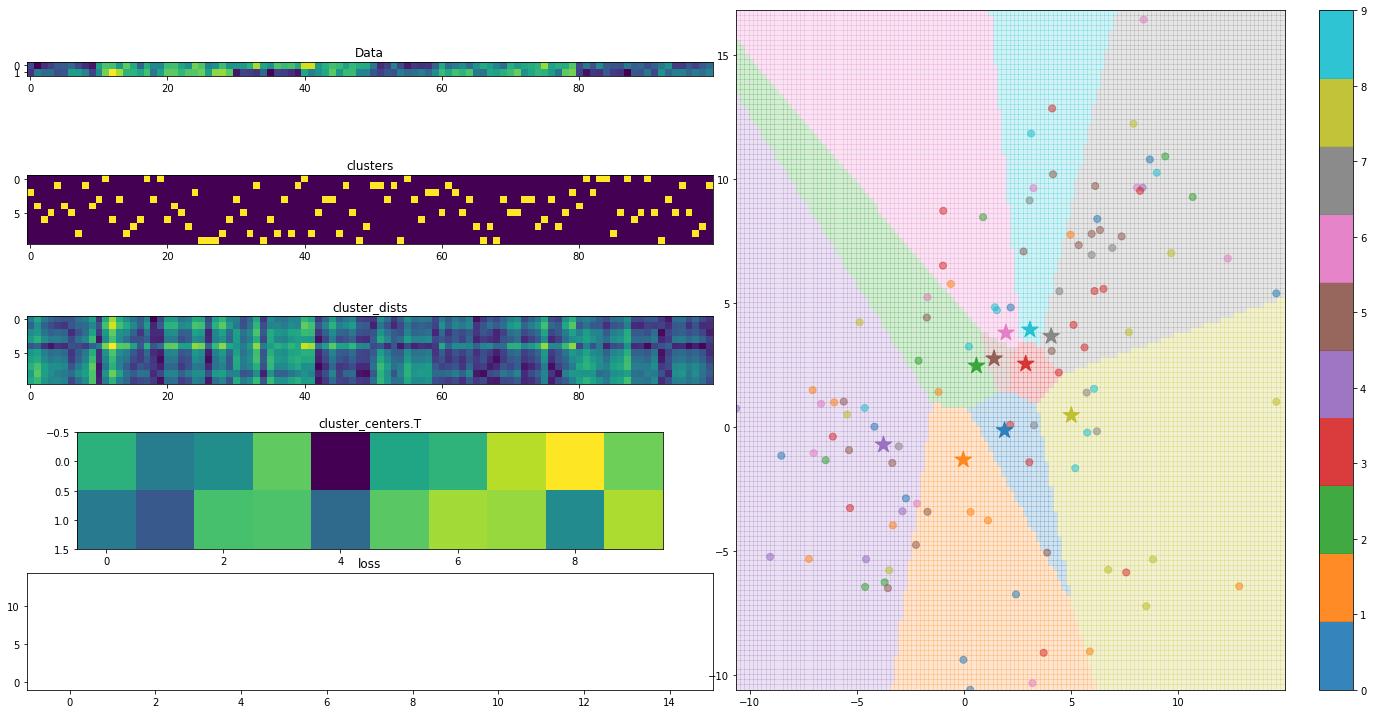

In [5]:
km_plot = KMeansPlot(add_2d=(data.shape[-1] == 2))
cd_all=[cd]
km_plot.setup(data, topics, cluster_centers, cluster_dists, new_topics, cd_all);
km_plot.close()
# show_plots(data, topics, cluster_centers, cluster_dists, new_topics);

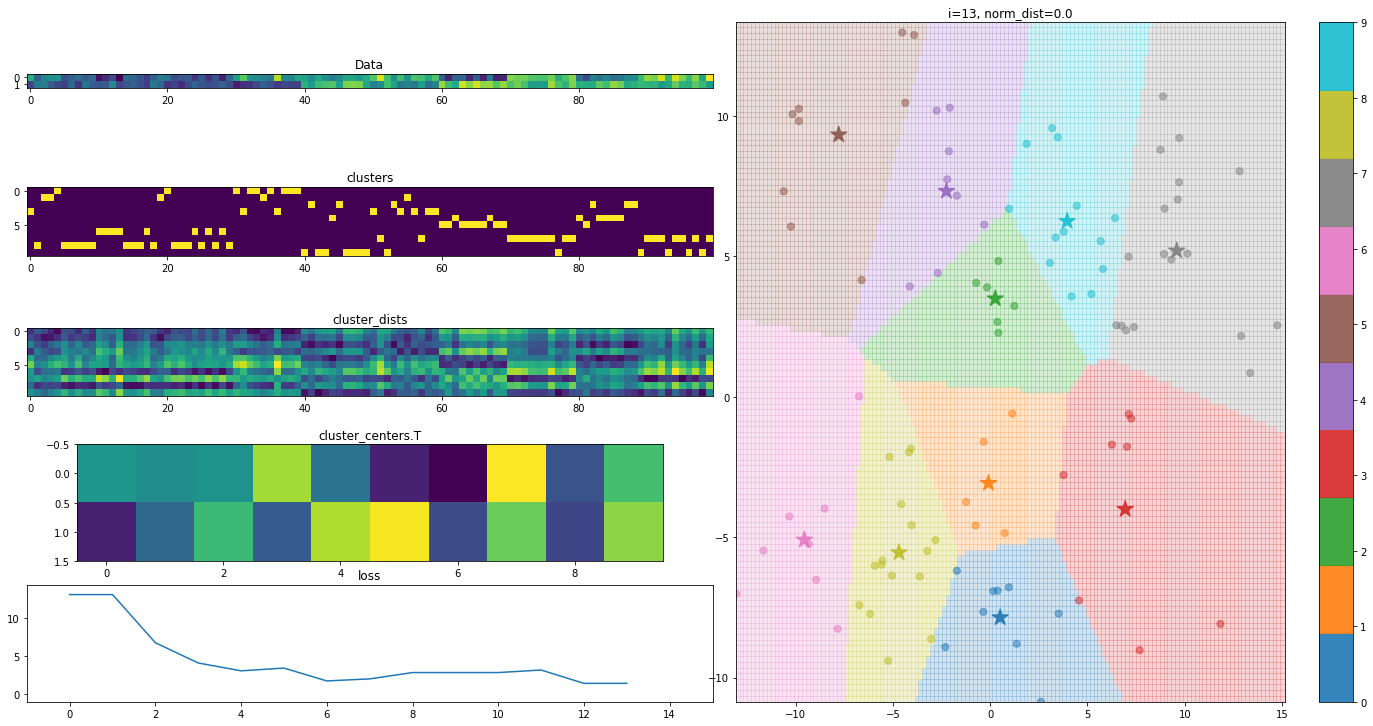

In [6]:
data = get_data(N, d, k)
topics = get_init_topics(data, k=k)
cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
new_topics.sum(axis=-1)
km_plot = AnimatedKMeansPlot(add_2d=add_2d)
# km_plot.get_animator_funcs(data, k)
topics = get_init_topics(data, k=k)
cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
cd_all = [cd]
km_plot.setup(data, topics, cluster_centers, cluster_dists, new_topics, cd_all);
for i in range(20):
  cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
  title = f"i={i}, norm_dist={cd}"
  km_plot.update(data, topics, cluster_centers, cluster_dists, new_topics, cd_all, title);
  cd_all.append(cd)
  topics = new_topics

  if cd < 1e-5:
    break

km_plot.close()

# fig = plt.figure()
# plt.plot(cd_all)

In [7]:
km_plot = AnimatedKMeansPlot(add_2d=add_2d, use_display=False)
topics = get_init_topics(data, k=k)
init, update = km_plot.get_animator_funcs(data, topics)

<Figure size 1800x900 with 0 Axes>

In [8]:
topics.T @ topics

array([[ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]])

In [9]:
cd_all

[13.038404810405298,
 13.038404810405298,
 6.733003292240699,
 4.082482904641035,
 3.0550504633499727,
 3.4156408559584492,
 1.731820738602555,
 2.0000000442162844,
 2.8284271247461903,
 2.8284271247461903,
 2.8284271247461903,
 3.1622776601683795,
 1.4142135623730951,
 1.4142135623730951,
 0.0]

In [10]:
data = get_data(N, d, k)
with plt.style.context('dark_background'):
  km_plot = AnimatedKMeansPlot(add_2d=add_2d, use_display=False)
  topics = get_init_topics(data, k=k)
  init, update = km_plot.get_animator_funcs(data, topics)

  animation = FuncAnimation(km_plot.fig, update, init_func=init, frames=15, interval=20, blit=True)
  animation.save('basic_animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
  km_plot.close()

show_video('basic_animation.mp4')

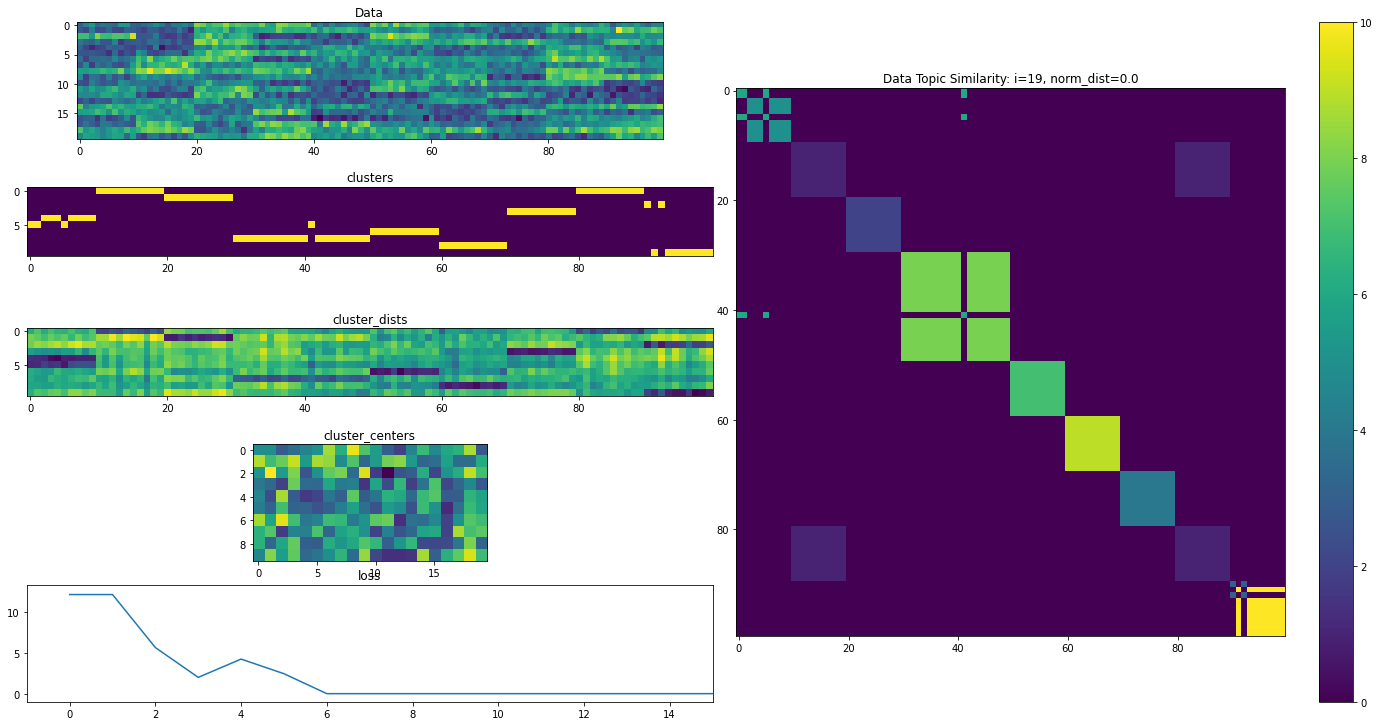

In [11]:
d = 20
add_2d = (d == 2)
data = get_data(N, d, k)
topics = get_init_topics(data, k=k)
# cluster_centers, cluster_dists, new_topics, cd = run_iteration(data, topics)
# cd_all = [cd]

km_plot = AnimatedKMeansPlot(add_2d=add_2d)
init, update = km_plot.get_animator_funcs(data, topics)

init()
for i in range(20):
  update(i)
km_plot.close()

In [12]:
d = 20
add_2d = (d == 2)
data = get_data(N, d, k)
with plt.style.context('dark_background'):
  km_plot = AnimatedKMeansPlot(add_2d=add_2d, use_display=False)
  topics = get_init_topics(data, k=k)
  init, update = km_plot.get_animator_funcs(data, topics)

  animation = FuncAnimation(km_plot.fig, update, init_func=init, frames=15, interval=20, blit=True)
  animation.save('basic_animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
  km_plot.close()

show_video('basic_animation.mp4')

In [13]:
(data @ data.T).shape

(100, 100)

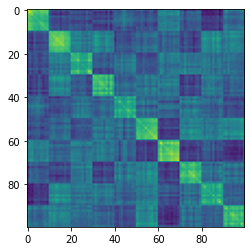

In [14]:
plt.imshow(data @ data.T)

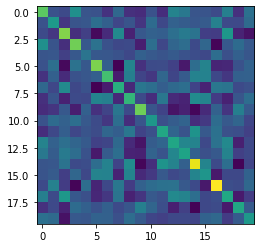

In [15]:
plt.imshow(data.T @ data)

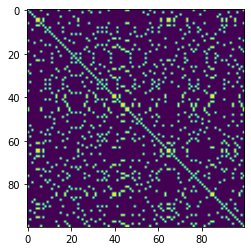

In [16]:
plt.imshow(topics @ topics.T)

In [17]:
(topics @ topics.T).mean(axis=-1)

array([0.12, 0.1 , 0.06, 0.06, 0.12, 0.12, 0.12, 0.12, 0.13, 0.06, 0.13,
       0.11, 0.04, 0.12, 0.12, 0.06, 0.13, 0.12, 0.14, 0.12, 0.11, 0.06,
       0.11, 0.12, 0.11, 0.1 , 0.14, 0.12, 0.12, 0.1 , 0.11, 0.12, 0.13,
       0.1 , 0.13, 0.14, 0.13, 0.12, 0.11, 0.12, 0.12, 0.13, 0.12, 0.14,
       0.14, 0.12, 0.12, 0.11, 0.14, 0.13, 0.04, 0.14, 0.04, 0.1 , 0.11,
       0.06, 0.12, 0.13, 0.1 , 0.14, 0.13, 0.12, 0.1 , 0.12, 0.12, 0.12,
       0.1 , 0.12, 0.06, 0.14, 0.06, 0.12, 0.11, 0.12, 0.13, 0.14, 0.12,
       0.14, 0.13, 0.06, 0.04, 0.12, 0.11, 0.14, 0.12, 0.12, 0.11, 0.06,
       0.06, 0.12, 0.13, 0.12, 0.1 , 0.06, 0.14, 0.12, 0.1 , 0.12, 0.14,
       0.12])

In [18]:
(topics @ topics.T)

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [19]:
(topics @ topics.T) * topics.argmax(axis=-1)

array([[3., 0., 0., ..., 0., 0., 3.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 9., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 5., 0., 0.],
       [0., 0., 0., ..., 0., 4., 0.],
       [3., 0., 0., ..., 0., 0., 3.]])

In [20]:
((topics @ topics.T).mean(axis=-1)) * topics.argmax(axis=-1)

array([0.36, 0.2 , 0.54, 0.06, 0.  , 0.  , 0.36, 0.  , 0.91, 0.54, 0.91,
       0.88, 0.24, 0.6 , 0.36, 0.06, 0.91, 0.6 , 0.56, 0.36, 0.88, 0.06,
       0.88, 0.  , 0.88, 0.2 , 0.56, 0.6 , 0.36, 0.2 , 0.88, 0.6 , 0.91,
       0.2 , 0.91, 0.56, 0.91, 0.36, 0.88, 0.6 , 0.6 , 0.91, 0.6 , 0.56,
       0.56, 0.36, 0.36, 0.88, 0.56, 0.91, 0.24, 0.56, 0.24, 0.2 , 0.88,
       0.54, 0.36, 0.91, 0.2 , 0.56, 0.91, 0.  , 0.2 , 0.6 , 0.  , 0.  ,
       0.2 , 0.  , 0.06, 0.56, 0.54, 0.6 , 0.88, 0.  , 0.91, 0.56, 0.36,
       0.56, 0.91, 0.54, 0.24, 0.36, 0.88, 0.56, 0.6 , 0.6 , 0.88, 0.06,
       0.54, 0.  , 0.91, 0.  , 0.2 , 0.06, 0.56, 0.  , 0.2 , 0.6 , 0.56,
       0.36])

In [21]:
((topics @ topics.T) @ ((topics @ topics.T).mean(axis=-1)) @ topics.argmax(axis=-1))

553.7100000000002

In [22]:
(topics.T @ topics)/ np.diag(topics.T @ topics).sum()

array([[0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06]])

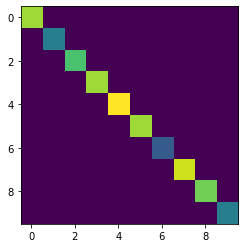

In [23]:
plt.imshow((topics.T @ topics)/ np.diag(topics.T @ topics).sum())

In [24]:
np.vstack([np.eye(topics.shape[1]), np.zeros_like(topics[:1, :]), topics]).shape

(111, 10)

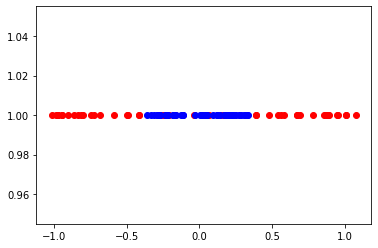

In [25]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=100, shuffle=True, factor=0.3, noise=0.05, random_state=0)
plt.plot(X[y==0, 0], np.ones_like(X[y==0, 0]), "ro")
plt.plot(X[y==1, 0], np.ones_like(X[y==1, 0]), "bo")

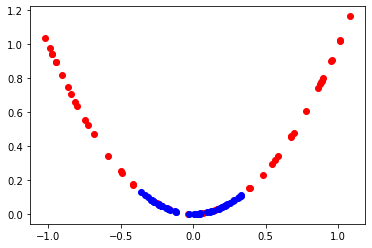

In [26]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=100, shuffle=True, factor=0.3, noise=0.05, random_state=0)
plt.plot(X[y==0, 0], X[y==0, 0]**2, "ro")
plt.plot(X[y==1, 0], X[y==1, 0]**2, "bo")

In [27]:
np.linalg.norm(X, axis=-1)

array([0.97908172, 0.26293587, 0.97432766, 0.26465007, 0.33381712,
       0.26349536, 0.91874572, 0.28431005, 0.30386728, 0.25505336,
       0.28043995, 0.36246268, 0.27994776, 1.07470414, 0.97082356,
       0.985455  , 0.99424436, 0.95159776, 0.98672183, 1.03544514,
       1.00145148, 0.30350331, 0.99402231, 0.31186698, 1.07943851,
       1.06089736, 0.95427542, 0.35079544, 0.17962685, 0.23467468,
       0.3100841 , 0.40091691, 0.29598645, 0.33043868, 0.31440176,
       1.00159953, 1.04123536, 0.3271167 , 0.38929438, 0.2884669 ,
       1.08443187, 0.28219207, 1.05717722, 1.04077529, 1.01871747,
       1.0745091 , 1.08116759, 0.9986309 , 1.079247  , 0.9606756 ,
       0.27868118, 0.24275193, 0.95650061, 1.01734933, 0.96814958,
       0.33732999, 1.04865397, 1.06723776, 0.99468535, 0.29141274,
       1.01686328, 0.98711182, 0.35904678, 0.2509954 , 0.41069648,
       0.35005731, 0.95751836, 0.34654037, 0.96271856, 0.41259706,
       1.00221221, 1.10255329, 1.01804897, 0.32219273, 0.32291

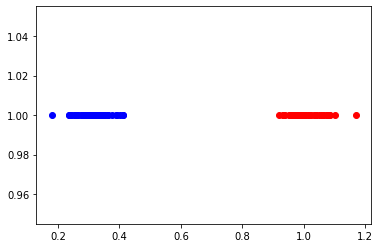

In [28]:


# X, y = make_circles(n_samples=100, shuffle=True, factor=0.3, noise=0.05, random_state=0)
X_norm = np.linalg.norm(X, axis=-1)
plt.plot(X_norm[y==0], np.ones_like(X[y==0, 0]), "ro")
plt.plot(X_norm[y==1], np.ones_like(X[y==1, 0]), "bo")